# Convert CIFAR-10 Image files to TF Record 

Apache beam is distributed parallel data processing framework.<BR>
To make TFRecord data, it may takes long time with single machine. <BR>
So in this notebook, it will show the way to parallelize image file to TFRecord files <BR>
Original image files are stored in image directory and the name of the file and label are stored in CSV file. In apache beam, it will read the CSV file and based on the filename in the csv file, it will read image file and convert & merge into number of tf records files
<p>
Reference 
<li> https://github.com/tensorflow/transform/blob/master/examples/census_example.py </li>
<li>https://github.com/GoogleCloudPlatform/cloudml-samples/blob/master/flowers/trainer/preprocess.py </li>
<li>https://beam.apache.org/documentation/sdks/pydoc/2.2.0/apache_beam.io.tfrecordio.html</li>
<li>https://gist.github.com/wwoo/42523488abb1b788a06a9775fe2329d9</li>

<p>

please install apache_beam SDK first <br>
you can use "pip install apache-beam" command <br>
for GCP features "pip install apache-beam[gcp]"<br>



## Dataflow configuration

In [1]:
# CONFIGURATIONS

SRC_DIR_DEV = '/Users/terrycho/dev/workspace/cifar-10/data/images'
DES_DIR_DEV = '/Users/terrycho/dev/workspace/cifar-10/data/tfrecords'
LOCAL_TMP_DIR='/tmp/'
#SRC_BUCKET
DES_BUCKET='terrycho-cifar-10'
SRC_DIR_PRD = 'gs://terrycho-cifar-10/data/images'
DES_DIR_PRD = 'gs://terrycho-cifar-10/data/tfrecords'
PROJECT='terrycho-sandbox'

SRC_DIR=''
DES_DIR=''

DEV_MODE=False


## Define Python dependency 

If you run apache beam code in google data flow. The whole code will be uploaded into google cloud dataflow service. <br>
In the upload, all dependency files needs to be uploaded together.<br>
You can define python dependcy into requirements.txt file 
<p>
please reference https://cloud.google.com/dataflow/pipelines/dependencies-python


In [2]:
%%writefile requirements.txt
Pillow==3.3.1
ipython==5.3.0
ipython-genutils==0.2.0
google-api-python-client==1.6.2
google-cloud-storage==1.6.0

Overwriting requirements.txt


In [3]:
import apache_beam as beam
import os
import datetime
import numpy as np
import io
import tensorflow as tf
import google.auth

from google.cloud import storage
from PIL import Image
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions

from tensorflow.python.framework import errors
from tensorflow.python.lib.io import file_io

# set service account file into OS environment value
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/terrycho/keys/terrycho-sandbox-projectowner.json"
job_name = 'cifar-10'+ datetime.datetime.now().strftime('%y%m%d%H%M%S')

options = {
    'staging_location': 'gs://'+DES_BUCKET+'/staging',
    'temp_location': 'gs://'+DES_BUCKET+'/tmp',
    'job_name': job_name,
    'project': PROJECT,
    'zone' : 'asia-northeast1-c',
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True ,  
    'requirements_file' : 'requirements.txt',
    'save_main_session': True
}
opts = beam.pipeline.PipelineOptions(flags=[], **options)

if(DEV_MODE):
    RUNNER = 'DirectRunner'
    inputfiles = SRC_DIR_DEV +'/data_batch_1.csv'
    SRC_DIR=SRC_DIR_DEV
    DES_DIR=DES_DIR_DEV+'/'
else:
    inputfiles = SRC_DIR_PRD +'/data_batch_1.csv'
    SRC_DIR=SRC_DIR_PRD
    DES_DIR=DES_DIR_PRD+'/'
    RUNNER = 'DataflowRunner'

# Apache beam functions
def parseCSV(element):
    line = str(element)
    e = line.split(',')
    filename = str(e[0])
    label = int(e[1])
    return filename,label

def readImage(element):
    filename,label = element

    filepath=''
    if(DEV_MODE):
        filepath = SRC_DIR+'/'+filename
    else:
        #download file from gcs to local
        storageClient = storage.Client()
        source_bucket = storageClient.get_bucket(DES_BUCKET)
        blob = source_bucket.get_blob('data/images/'+filename)
    
        # 1) download file
        filepath = LOCAL_TMP_DIR+filename
        with open(filepath,'wb') as file_obj:
            blob.download_to_file(file_obj)

    print('[MYLOG] read image :'+filepath)
    image = open(filepath,'rb')
    #image_bytes = image.read()
    #img = np.array(Image.open(io.BytesIO(image_bytes)).convert('RGB'))
    #img_raw = img.tostring()
    #print img_raw
    bytes = image.read()
    image.close()
    
    # if it is running over dataflow, delete temp file
    if(DEV_MODE==False):
        os.remove(filepath)
        
    return bytes,label

class TFExampleFromImageDoFn(beam.DoFn):
    def process(self,element):
        def _bytes_feature(value):
          return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

        def _float_feature(value):
          return tf.train.Feature(float_list=tf.train.FloatList(value=value))

        def _int64_feature(value):
          return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
        try:
            element = element.element
        except AttributeError:
            pass
        bytes,label = element
        
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': _bytes_feature([bytes]),
            'label':_int64_feature([label])
        }))
        
        yield example
        
#def ImageToTfRecord(imagefile,label):

def run():
    p = beam.Pipeline(RUNNER,options=opts)
    l = (p
         | 'Read CSV' >> ReadFromText(inputfiles)
         | 'Parse CSV' >> beam.Map(parseCSV)
         | 'ReadImage' >> beam.Map(readImage)
         | 'Convert Image and Label to tf.train.example' >> beam.ParDo(TFExampleFromImageDoFn())
         | 'Serialized to String' >> beam.Map(lambda x:x.SerializeToString())
         | 'Save To Disk' >> beam.io.WriteToTFRecord(DES_DIR+'cifar-10',file_name_suffix='.tfrecord')
        )
    job = p.run()
    job.wait_until_finish()
    
run()
print('Done')

No handlers could be found for logger "oauth2client.contrib.multistore_file"
/Users/terrycho/anaconda/envs/tensorflow13/lib/python2.7/site-packages/apache_beam/io/gcp/gcsio.py:122: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/Users/terrycho/anaconda/envs/tensorflow13/lib/python2.7/site-packages/apache_beam/coders/typecoders.py:134: UserWarning: Using fallback coder for typehint: <type 'NoneType'>.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
/Users/terrycho/anaconda/envs/tensorflow13/lib/python2.7/site-packages/apache_beam/coders/typecoders.py:134: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Done


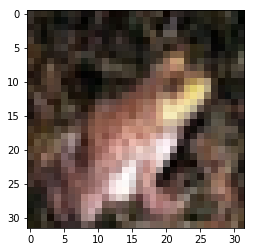

Label : SparseTensorValue(indices=array([[0]]), values=array([6]), dense_shape=array([1]))


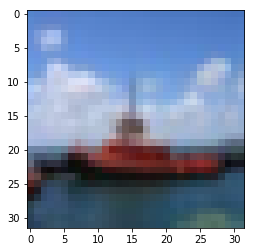

Label : SparseTensorValue(indices=array([[0]]), values=array([8]), dense_shape=array([1]))


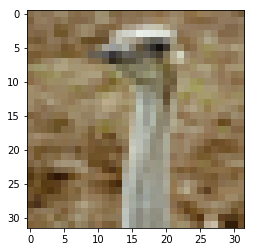

Label : SparseTensorValue(indices=array([[0]]), values=array([2]), dense_shape=array([1]))


In [9]:
# read tfrecord and print image and label

import tensorflow as tf
from PIL import Image
import io
import matplotlib.pyplot as plt

#tfrecord_filename = DES_DIR+'cifar-10-00000-of-00010.tfrecord'
tfrecord_filename = '/Users/terrycho/Downloads/data-tfrecords-cifar-10-00007-of-00030.tfrecord'
def readRecord(filename_queue):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    keys_to_features = {
      'image_raw': tf.FixedLenFeature((), tf.string, default_value=''),
      'label': tf.VarLenFeature(tf.int64),
    }
    
    features = tf.parse_single_example(serialized_example,features= keys_to_features)
    
    encoded = tf.cast(features['image_raw'],tf.string)
    label = tf.cast(features['label'],tf.int64)

    return encoded,label
    
def main():
     filename_queue = tf.train.string_input_producer([tfrecord_filename])
     encoded,label = readRecord(filename_queue)
     
     init_op = tf.global_variables_initializer()

     with tf.Session() as sess:
         sess.run(init_op)
    
         coord = tf.train.Coordinator()
         threads = tf.train.start_queue_runners(coord=coord)

         for i in range(0,3):
             encoded_value,label_value = sess.run([encoded,label])
             image = Image.open(io.BytesIO(encoded_value))
             plt.imshow(image)
             plt.show()
             print('Label : '+str(label_value))

         coord.request_stop()
         coord.join(threads)
         
main()